In [1]:
%matplotlib inline

In [2]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import os.path

In [3]:
# test result function
def frobenius_norm(M1, M2):
    #print M1
    #print M2
    total = 0.0
    for a,b in zip(M1, M2):
        for c, d in zip(a, b):
            total += (c - d)*(c - d)
    return total

In [4]:
# dimension of each example in the dataset
d = 15
# k is the top pricipal calculated by the eigenvectors, right now just fix it
k = 5
# fix the learning rate
learning_rate = 0.00001
# preprocess the data
data_set = []
data_set_done = []
if os.path.exists('new_data_1'):
    with open('new_data_1') as data:
        for line in data:
            data_set_done.append(map(float, line.split()))

else:
    with open('adult.data.txt') as data:
        for line in data:
            # '\s' matches whitespace
            tmp = re.sub(r'\s', '', line).split(',')
            data_set.append(tmp)
    print data_set

    feature_vector_size = len(data_set[0])
    print "feature vector is  " ,feature_vector_size
    print "data set size is ", len(data_set)
    tmp = data_set[0]

    # find out which feature is not a digit
    non_digit_index = []
    for i in range (0,feature_vector_size):
        if tmp[i].isdigit():
            continue
        else:
            non_digit_index.append(i)
    print non_digit_index

    # make each string feature to become a number

    # Copy
    modified_data_set= []
    for item in data_set:
        modified_data_set.append(item)


    print "data before processed dimension is ", len(modified_data_set[0])
    #print modified_data_set
    item_list = []
    count = 0
    dimension_to_increase = 0
    # for all the non_digit index, count how many differnt items
    for i in non_digit_index:
        # clear the item list to find different string for same feature
        items = []
        # loop through the whole data set
        for vector in data_set:
            # get the corresponsding item
            tmp = vector[i]
            # it already in the list
            if tmp in items:
                continue
            else:
                # otherwise append to the list
                items.append(tmp)
        dimension_to_increase = dimension_to_increase + len(items)-1
        #print "item is "
        #print items
        #print "\n\n"
        # loop through the whole data set to replace the feature
        for j in range(len(modified_data_set)):
            v = modified_data_set[j]
            #print v
            # get the item in the vector
            #print "accessing ", i+count
            tmp = v[i+count]
            index  = items.index(tmp)
            front = v[0:i+count]
            end = v[i+1+count:len(v)]
            zeros = [0]*len(items)
            zeros[index] = 1
            front.extend(zeros)
            front.extend(end)
            modified_data_set[j] = front
            #print "result is ", modified_data_set[j]
            #v[i] = float(index)
        count = count + len(items)-1
    for v in modified_data_set:
        v = map(float, v)
        data_set_done.append(v)
    print "dimension to increase ", dimension_to_increase
    print "data processed dimension is ", len(data_set_done[0])
    #print data_set_done
    print "size of data set done is ", len(data_set_done)

f = open('new_data', 'w')
for vector in data_set_done:
    for num in vector:
        f.write(str(num)+" ")
    f.write("\n")
f.close()


In [5]:
# pre-process the data
# find the largest item in the column and divide by that number
d = len(data_set_done[0])
largest = 0.0
largest_list = []

# loop each column and find the largest element
for i in range(0,d):
    largest = 0.0
    for item in data_set_done:
        if item[i] >= largest:
            largest = item[i]
    largest_list.append(largest)

tmp = 0.0
for i in range(0,d):
    tmp = largest_list[i]
    # divide all the items by the largest one to normalize
    for item in data_set_done:
        item[i] = item[i]/tmp
    
f = open('new_data_1', 'w')
for vector in data_set_done:
    for num in vector:
        f.write(str(num)+" ")
    f.write("\n")
f.close()

In [6]:
# helper function to normalize a vector
# v = np.array([[x1,x2]])
def normalizeVector(v):
    distance = 0.0
    for i in v:
        for j in i:
            distance = distance + j**2
    distance = math.sqrt(distance)
    v = v/distance
    return v

# helper function to calculate the distance between two vectors
# v1 = np.array([[x1,x2]])
# v2 = np.array([[x1,x2]])
def distance(v1,v2):
    distance = 0.0
    for i,j in zip(v1,v2):
        for x, y in zip(i, j):
            distance = distance + (x- y)**2
    distance = math.sqrt(distance)
    return distance

# v is np.array([[x1,x2,x3....]])
# v is column-major vector
# the test function compute the sum of distance between X and (v, X)* v
def testFunction(v):
    total = 0.0
    for item in data_set_done:
        tmp = np.array([item])
        dotProduct = np.dot(tmp,v) # dotproduct should be a constant
        dotProduct = dotProduct * v # dotproduct is a column major vector
        total = total + distance(tmp,dotProduct)**2   
    return total

In [7]:
# data set size covariance matrix M
N = len(data_set_done)
M = np.array(data_set_done[0]) * np.transpose(np.array(data_set_done[0])) / N

# M is (sum of data elements * transpose of data element) / size of data
for i in range(1, len(data_set_done)):
    M = M + (np.array([data_set_done[i]]) * np.transpose(np.array([data_set_done[i]]))) / N

U, s, V = np.linalg.svd(M, full_matrices=True)
# U is 110 x 110, s is 110 x 1, V is 110 x 110

In [8]:
X = np.array([U[:,0]])
X.reshape(110,1) #Convert to a correct matrix type for the test function
print "U's base line is ", testFunction(np.transpose(X))

X = np.array([V[0]])
X.reshape(110,1) #Convert to a correct matrix type for the test function
print "V's base line is ", testFunction(np.transpose(X))
baseline = testFunction(np.transpose(X))

U's base line is  837.16382399
V's base line is  837.190526185


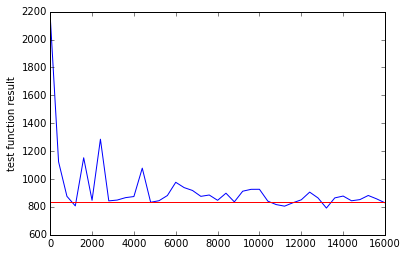

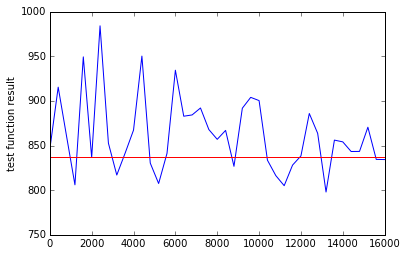

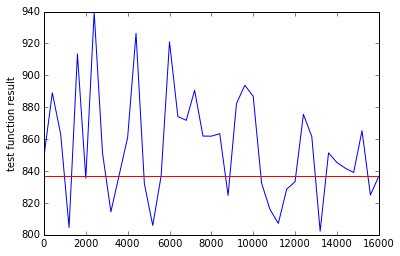

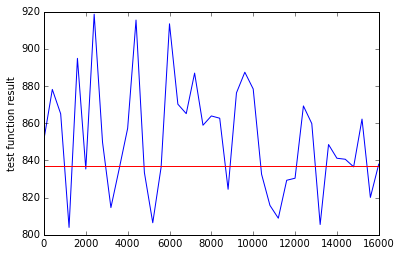

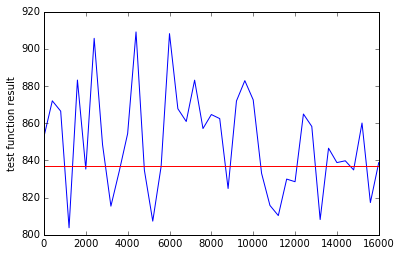

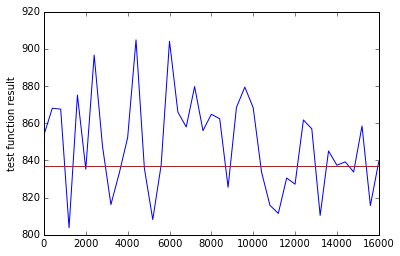

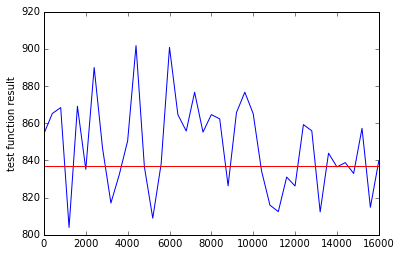

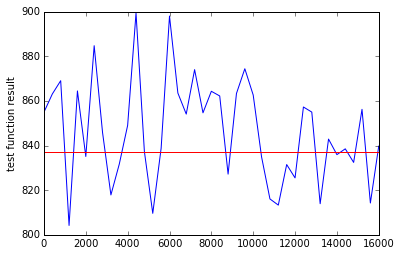

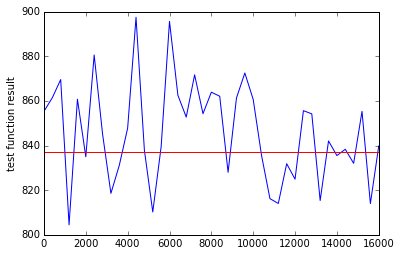

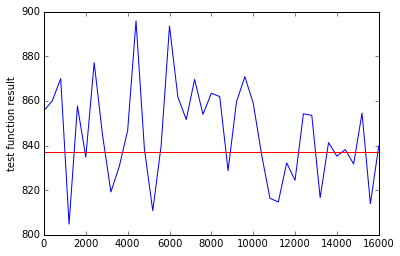

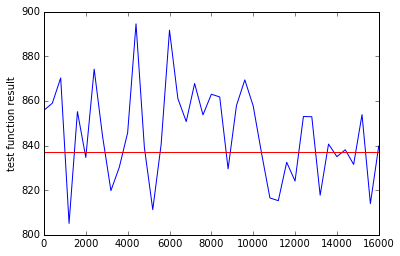

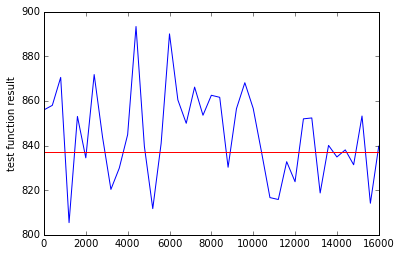

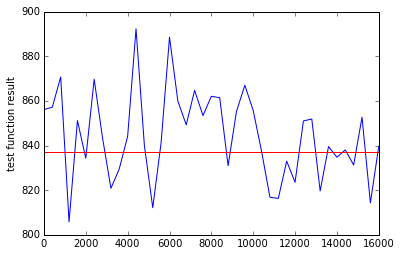

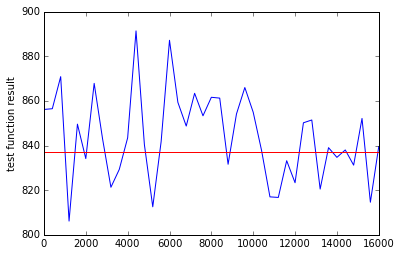

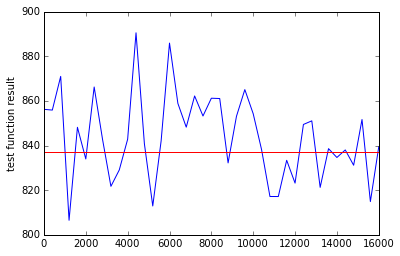

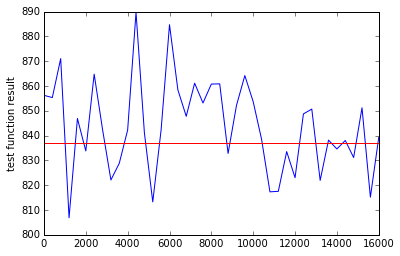

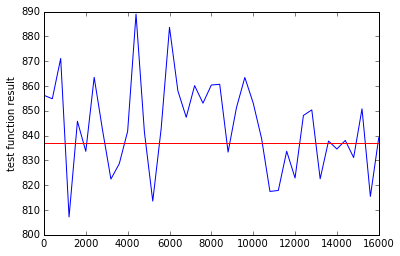

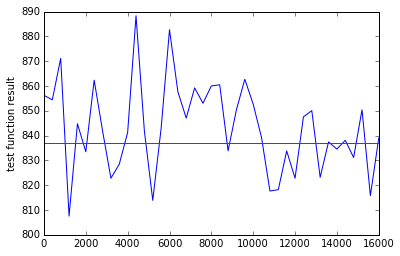

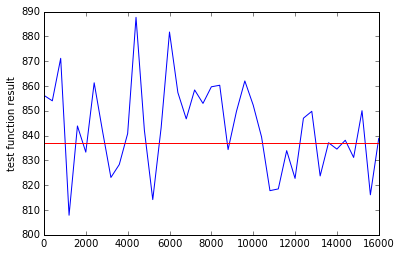

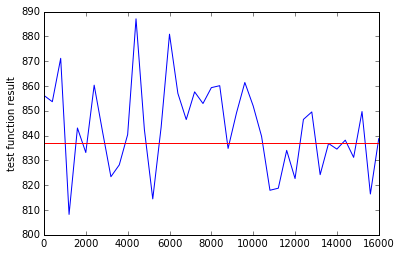

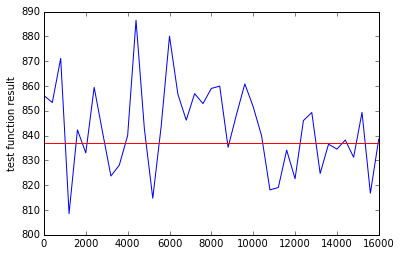

In [9]:
'''
    Implement Oja's rule to find the top k pricipal components of the dataset
'''

# initialize v0 as a vector drawn uniformly at raondom on the surface of a d-dimensional sphere
d = len(data_set_done[0])
v1 = []
prev_v = [] # record the previous v1 to test convergence
s = 0.0
t = len(data_set_done) # t is the data set lenght: how many data points there are
learning_rate = 1.0
# random intialize a vector from a d-dim sphere
for i in range(0,d):
    tmp = np.random.random()
    s = s + tmp**2
    v1.append(tmp)
    prev_v.append(0.0)

s = math.sqrt(s)
# normalize v1 
for i in range(0,d):
    v1[i] = v1[i] * 1.0/ s

a = np.dot(np.array([data_set_done[0]]),np.transpose(np.array([data_set_done[0]])))

dis = 0.0
loop = 0.0
# test convergence
v1 = np.array([v1]) # v1 type np.array([[x1,x2]]) 
v1 = np.transpose(v1) # let v1 becomese a column major vector
prev_v = v1
testResult = []
tPoint = []

# stil have the infinite problem, need to normalize feature
while True:
    testResult = []
    tPoint = []
    #print "loop is ", loop
    for i in range(0, len(data_set_done)/2):
        loop = loop + 1
        learning_rate = 1.0/math.sqrt(loop)
        tmp = data_set_done[i] # convert to right form
        tmp = np.array([tmp])
        b = np.dot(np.transpose(tmp),tmp)
        b = np.dot(b,v1) # result will be a 110 * 1 vector
        v1 = v1 + learning_rate * b 
        v1 = normalizeVector(v1)
        if i % 400 == 0:
            tPoint.append(i)
            test = testFunction(v1)
            testResult.append(test)
    plt.plot(tPoint, testResult, '-')
    plt.axhline(baseline, color='r')
    plt.ylabel('test function result')
    plt.show()
    dis = distance(prev_v,v1)
    if dis <= 0.001:
            break
    prev_v = v1

In [22]:
# put all the data into the new list where each data is subtract with the projection
v1_project = []
for i in range(0, len(data_set_done)):
    v1_project.append(np.dot(v1.reshape(1,110)[0], data_set_done[0]) * v1.reshape(1,110))
